In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D

In [4]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [5]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

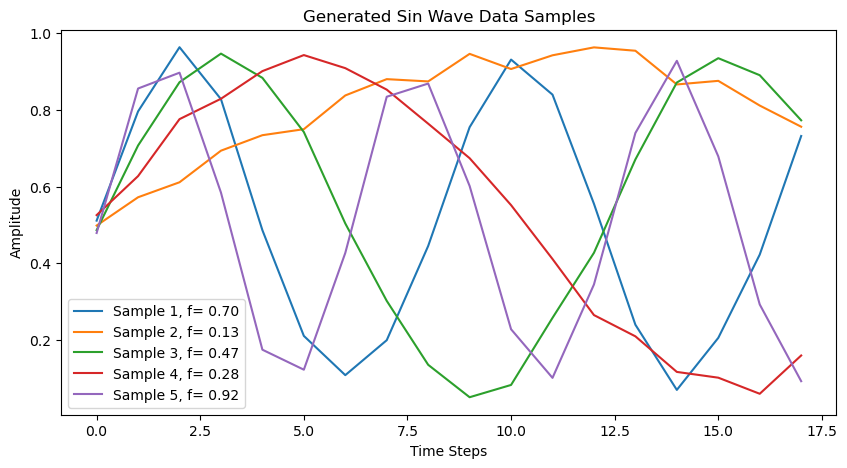

In [6]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [7]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 5),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 7,
}

CNN_classical = CNN_1D(hparams=hparams)

In [8]:
# change model to float64
CNN_classical = CNN_classical.double()

In [9]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical.train()
optimizer = torch.optim.Adam(
    CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.43495840872384467


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.13454037267565447


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.11250698770982832


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.0942115132418564


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.07478784505948272


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.0738416526799793


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.06672303128767723


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.0730493062857846


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.07619116202991971


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.06916218949368533


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.06590079382978152


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.06470384028760498


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.06289050697753835


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.047395335392980686


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.04775279152731815


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.029693875367438692


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.020960635108644113


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.01937917942220678


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.014292870005731104


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.016643816344721143


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.016743021463176026


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.015323312006152248


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.010250963508272388


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.01192459652191958


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train loss: 0.011073700922424748


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train loss: 0.009424962356519937


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train loss: 0.013365623390386494


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train loss: 0.010699243013879202


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train loss: 0.010331078883203412


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train loss: 0.009123397465435567


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train loss: 0.00603686660065166


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train loss: 0.009437095601550868


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train loss: 0.011034585355692817


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train loss: 0.009499760384219354


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train loss: 0.0075578729310244175


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train loss: 0.009235632978884092


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train loss: 0.00955024287461071


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train loss: 0.009222534082699655


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train loss: 0.011128254864836517


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train loss: 0.007519274570289537


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train loss: 0.008566006271015789


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train loss: 0.006544932497137121


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train loss: 0.006996982654485744


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train loss: 0.00707709543357417


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train loss: 0.006008654820976492


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train loss: 0.011786930905158652


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train loss: 0.010575579789208754


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train loss: 0.009002429384752155


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train loss: 0.008207126091286425


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train loss: 0.008324870793743493
Final loss (MSE): 0.00813072319089253
Final loss (RMSE): 0.09017052284916913


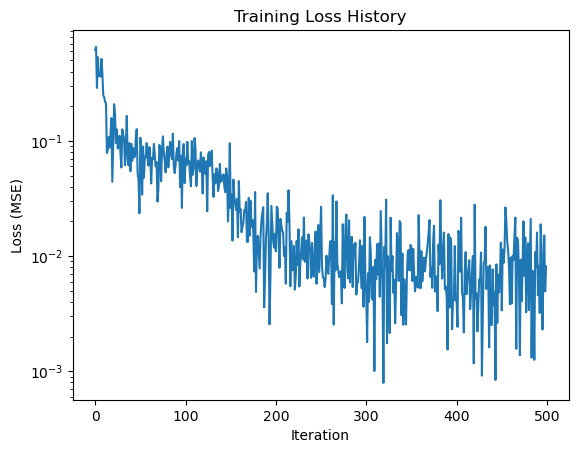

In [10]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [11]:
# test the model
CNN_classical.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
    predicted = CNN_classical(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.0006976609064237183
Test loss (RMSE): 0.026413271407073346


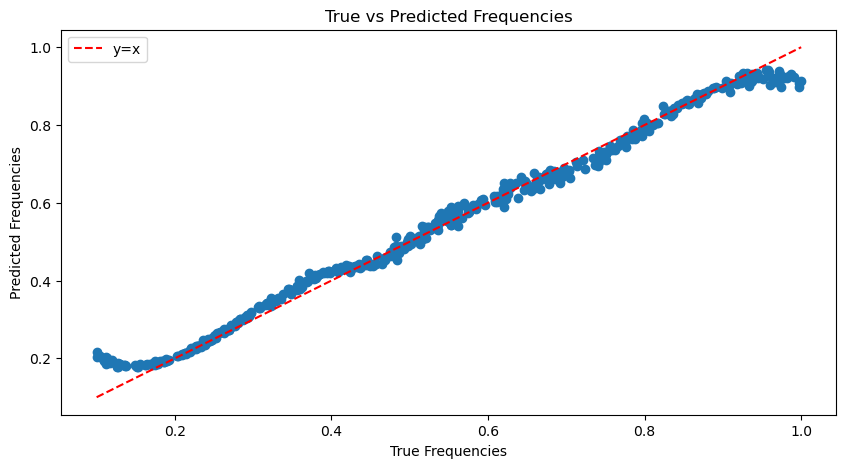

In [12]:
# plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_test_tmp, predicted.numpy())
# diagonal line
plt.plot([y_test_tmp.min(), y_test_tmp.max()], [y_test_tmp.min(), y_test_tmp.max()], 'r--', label='y=x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("True Frequencies")
plt.ylabel("Predicted Frequencies")
plt.legend()
plt.show()

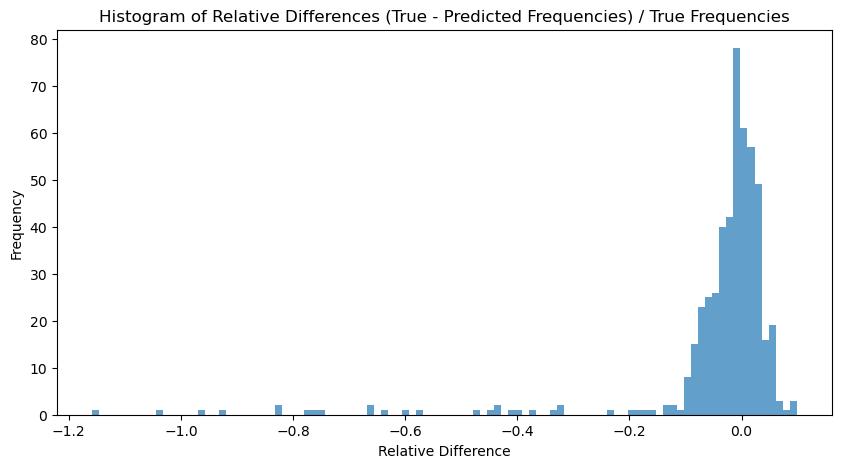

In [13]:
diffs = y_test.squeeze(1) - y_pred_test
rel_diffs = diffs / y_test.squeeze(1)  # relative differences
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(rel_diffs, bins=100, alpha=0.7)
plt.title("Histogram of Relative Differences (True - Predicted Frequencies) / True Frequencies")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.show()

In [14]:
# get the number of learned parameters of the model
n_params = sum(p.numel() for p in CNN_classical.parameters() if p.requires_grad)
print(f"Number of learned parameters: {n_params}")

Number of learned parameters: 163


In [15]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

# With Learned Channel Collapse

In [16]:
from source.NAHEA_CNN import CNN_1D_Learned_Channel_Collapse

In [17]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 5),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 6,
}

CNN_classical_2 = CNN_1D_Learned_Channel_Collapse(hparams=hparams)
CNN_classical_2 = CNN_classical_2.double()

In [18]:
n_params = sum(p.numel() for p in CNN_classical_2.parameters() if p.requires_grad)
print(f"Number of learned parameters: {n_params}")

Number of learned parameters: 164


In [19]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical_2.train()
optimizer = torch.optim.Adam(
    CNN_classical_2.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical_2.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = CNN_classical_2(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical_2.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.07360583577124835


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.06462109287964588


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.0625082034616207


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.06241899028349206


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.048142853660677665


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.020660670353123897


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.01175655856511296


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.011174181227340596


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.015078881885667514


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.006873946458008722


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.006229025190829725


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.008417789459287514


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.006729290611680686


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.007625869857020023


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.006316274022146957


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.006344615721502486


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.007477894066402544


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.00579594740008422


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.006442193307057574


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.009228689059431226


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.005851031743821259


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.0073818634579011335


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.006109813725316358


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.004493410345611629


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train loss: 0.005921544515655882


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train loss: 0.00554390032775266


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train loss: 0.00581208634927185


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train loss: 0.007399179454339148


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train loss: 0.011243049778591464


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train loss: 0.007362423957354043


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train loss: 0.00484448133624906


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train loss: 0.005404969651712548


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train loss: 0.005342169298589478


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train loss: 0.0056797584038899614


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train loss: 0.004899470242571568


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train loss: 0.006341477158720457


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train loss: 0.004520724696480418


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train loss: 0.005868768879624007


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train loss: 0.005568415552105005


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train loss: 0.004449751020514064


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train loss: 0.004872770666276965


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train loss: 0.00493206438431173


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train loss: 0.0069664441243436044


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train loss: 0.004844589097899033


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train loss: 0.007055021886476972


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train loss: 0.0046571511706644895


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train loss: 0.0023876468439516076


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train loss: 0.006625323137652695


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train loss: 0.0061619610306749536


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train loss: 0.004306981282398983
Final loss (MSE): 0.0014213044000890244
Final loss (RMSE): 0.03770019098212931


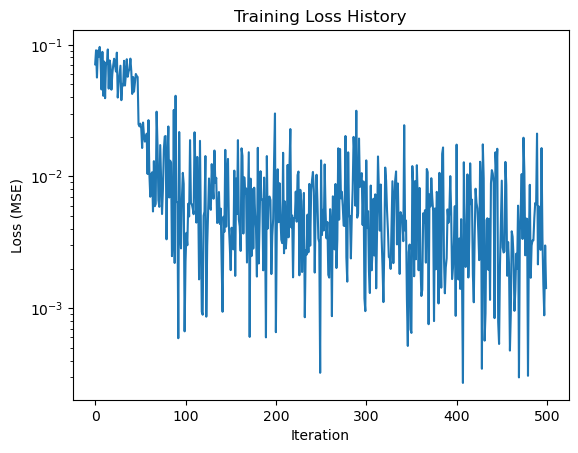

In [22]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [20]:
# test the model
CNN_classical_2.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
    predicted = CNN_classical_2(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.000603430339739486
Test loss (RMSE): 0.02456481914729856


In [21]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_Learned_Channel_Collpase_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )